## Image classification with deep learning methods.

-- Description --

When you train the network, it is recommended to use the GPU resources of your computer.
This will help you to learn the "know how" of setting up a working Python environment on your computer.
In the case of unavailable Nvidia hardware or problems with your Python environment you can use Google Colab.
Please go to the menu, Runtime - Change runtime type, and select **GPU** as the hardware accelerator.
Although you used your computer successfuly it is highly recommended to give a try to Google Colab environment.


In [ ]:
# Import libraries
# These libraries should be sufficient for this Practice.
# However, if any other library is needed, please install it by yourself.

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import torch.utils.data as data
import numpy as np
import time
import os
import random
import matplotlib.pyplot as plt
from matplotlib import colors
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import roc_auc_score
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import tensorflow as tf

!pip install medmnist
import medmnist
from medmnist import *

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.4/88.4 kB 1.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached 

In [ ]:
# Parameters
NUM_EPOCHS = 20
BATCH_SIZE = 32
lr = 0.0001
DOWNLOAD_OK = True
data_flag = 'bloodmnist'
#data_flag = 'pneumomnist'
im_size = 64
info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
num_classes = len(info['label'])
N_IMAGES = 1000
data_labels = info['label']

# Tupla que contiene los valores asociados a los parámetros mostrados anteriormente,
# con el fin de mejorar la organización de dichos parámetros.
parameters = {"num_epochs": NUM_EPOCHS, "batch_size": BATCH_SIZE, "lr": lr, "download_ok": DOWNLOAD_OK,
              "data_flag": data_flag, "im_size": im_size,"info_task": task, "n_channels": n_channels,
              "num_classes": num_classes,"n_images":N_IMAGES, "data_labels": data_labels}

# Preprocesado de datos mediante la definición de la transformación de datos
def preprocessing_data(parameters):
  data_transform = transforms.Compose([
    transforms.Resize((parameters["im_size"],parameters["im_size"])),
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
  ])

  full_train_dataset = BloodMNIST(split="train", transform=data_transform, download=True)
  full_valid_dataset = BloodMNIST(split="val", transform=data_transform, download=True)
  full_test_dataset = BloodMNIST(split="test", transform=data_transform, download=True)

  idx_train = np.random.choice(len(full_train_dataset),size=1000,replace=False)
  train_dataset = [full_train_dataset[i] for i in idx_train]

  idx_valid = np.random.choice(len(full_valid_dataset),size=300,replace=False)
  valid_dataset = [full_valid_dataset[i] for i in idx_valid]

  idx_test = np.random.choice(len(full_test_dataset),size=600,replace=False)
  test_dataset = [full_test_dataset[i] for i in idx_test]

  train_loader = data.DataLoader(dataset=train_dataset, batch_size=parameters["batch_size"], shuffle=True)
  valid_loader = data.DataLoader(dataset=valid_dataset, batch_size=parameters["batch_size"], shuffle=False)
  test_loader = data.DataLoader(dataset=test_dataset, batch_size=parameters["batch_size"], shuffle=True)

  return train_loader, valid_loader, test_loader, train_dataset, valid_dataset, test_dataset

train_loader,valid_loader,test_loader,train_dataset,valid_dataset,test_dataset = preprocessing_data(parameters)

Using downloaded and verified file: /root/.medmnist/bloodmnist.npz
Using downloaded and verified file: /root/.medmnist/bloodmnist.npz
Using downloaded and verified file: /root/.medmnist/bloodmnist.npz


In [ ]:
## Your code

# Función que permite visualizar los aspectos fundamentales sobre cada
# dataset que se haya descargado/cargado previamente.
def dataset_visualizer(dataset,length_montage):
  for i in range(0,length_montage*length_montage):
    img = dataset[i][0]
    label = str(dataset[i][1]).replace('[','').replace(']','')
    figure = plt.figure(figsize=(2,2))
    plt.imshow(img.permute(1,2,0))
    plt.title(data_labels[label])
    plt.axis("off")
  plt.show()

# Visualizador de las imágenes a través de un pipeline DataLoader
def dataloader_visualizer(data_loader,num_batches):
  for batch_idx, (features, labels) in enumerate(data_loader):
      if batch_idx >= num_batches:
        break
      for i in range(len(features)):
        img = features[i].squeeze()
        label = str(labels[i]).replace('tensor([','').replace('])','')
        plt.figure(figsize=(2,2))
        plt.title(label)
        plt.imshow(img.permute(1,2,0))
        plt.axis('off')
        plt.show()

def net_model_visualizer(net_model):
  print(net_model)
  print('Total Parameters:',
       sum([torch.numel(p) for p in net_model.parameters()])
  )
  print('Trainable Parameters:',
       sum([torch.numel(p) for p in net_model.parameters() if p.requires_grad])
  )
dataset_visualizer(train_dataset,5)

#dataloader_visualizer(train_loader,1)
#dataloader_visualizer(valid_loader,1)
#dataloader_visualizer(test_loader,1)

In [ ]:
# Define a simple CNN model

def convolution(in_channels,out_channels):
  layer = nn.Sequential(
      nn.Conv2d(in_channels,out_channels,3),
      nn.ReLU(),
      nn.MaxPool2d(2,2)
  )

  return layer

class Net(nn.Module):
    def __init__(self, parameters):
        super(Net, self).__init__()
        #Define the desired deep learning model
        #Your code

        self.layer1 = nn.Sequential(
            nn.Conv2d(parameters["n_channels"],8,3),
            nn.ReLU(),
            nn.MaxPool2d(2,2)
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(8,16,3),
            nn.ReLU(),
            nn.MaxPool2d(2,2)
        )

        self.layer3 = nn.Sequential(
            nn.Conv2d(16,32,3),
            nn.ReLU(),
            nn.MaxPool2d(2,2)
        )

        self.layer4 = nn.Sequential(
            nn.Conv2d(32,64,3),
            nn.ReLU(),
            nn.MaxPool2d(2,2)
        )

        self.fc1 = nn.Linear(64,32)
        self.drop1 = nn.Dropout(0.33)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(32,parameters["num_classes"])

        #End your code

    def forward(self, x):
        #Your code
        #print(1, x.shape)
        x = self.layer1(x)
        #print(2, x.shape)
        x = self.layer2(x)
        #print(3, x.shape)
        x = self.layer3(x)
        #print(4, x.shape)
        x = self.layer4(x)

        #print(5, x.shape)
        x = F.adaptive_avg_pool2d(x,1).reshape(x.size(0),-1)

        #print(6, x.shape)
        x = self.fc1(x)
        x = self.drop1(x)
        x = self.relu1(x)
        #print(7, x.shape)
        x = self.fc2(x)
        #print(8, x.shape)

        return x

#def double_convultion(in_channels,out_channels):

#  conv_op = nn.Sequential(
#      nn.Conv2d(in_channels,out_channels,1),
#      nn.ReLU(True),
#      nn.Conv2d(out_channels,out_channels,1),
#      nn.ReLU(True)
#  )

#  return conv_op

#class UNetCNN(nn.Module):
#  def __init__(self,parameters):
#    super(UNetCNN,self).__init__()

#    self.max_pool2d = nn.MaxPool2d(2,2)

#    self.down_conv1 = double_convultion(parameters["n_channels"],64)
#    self.down_conv2 = double_convultion(64,128)
#    self.down_conv3 = double_convultion(128,256)
#    self.down_conv4 = double_convultion(256,512)
#    self.down_conv5 = double_convultion(512,1024)

#    self.up_trans1 = nn.ConvTranspose2d(1024,512,2,2)
#    self.up_conv1 = double_convultion(1024,512)
#    self.up_trans2 = nn.ConvTranspose2d(512,256,2,2)
#    self.up_conv2 = double_convultion(512,256)
#    self.up_trans3 = nn.ConvTranspose2d(256,128,2,2)
#    self.up_conv3 = double_convultion(256,128)
#    self.up_trans4 = nn.ConvTranspose2d(128,64,2,2)
#    self.up_conv4 = double_convultion(128,64)

#    self.final_layer = nn.Conv2d(64,parameters["num_classes"],1)

#  def forward(self,x):
#    print(x.shape)
#    down1 = self.down_conv1(x)
#    print(down1.shape)
#    down2 = self.max_pool2d(down1)
#    print(down2.shape)
#    down3 = self.down_conv2(down2)
#    print(down3.shape)
#    down4 = self.max_pool2d(down3)
#    print(down4.shape)
#    down5 = self.down_conv3(down4)
#    print(down5.shape)
#    down6 = self.max_pool2d(down5)
#    print(down6.shape)
#    down7 = self.down_conv4(down6)
#    print(down7.shape)
#    down8 = self.max_pool2d(down7)
#    print(down8.shape)
#    down9 = self.down_conv5(down8)
#    print(down9.shape)

#    up1 = self.up_trans1(down9)
#    print(up1.shape)
#    x = self.up_conv1(torch.cat([down7,up1],1))

#    up2 = self.up_trans2(x)
#    print(up2.shape)
#    x = self.up_conv2(torch.cat([down5,up2],1))

#    up3 = self.up_trans3(x)
#    print(up3.shape)
#    x = self.up_conv3(torch.cat([down3,up3],1))

#    up4 = self.up_trans4(x)
#    print(up4.shape)
#    x = self.up_conv4(torch.cat([down1,up4],1))

#    final_layer = self.final_layer(x)
#    return final_layer

#class ResNet18(nn.Module):
#  def __init__(self,parameters):
#    super(ResNet18, self).__init__()

#    self.conv1 = nn.Conv2d(parameters["n_channels"],64,7,2,3)
#    self.bn1 = nn.BatchNorm2d(64)
#    self.maxpool = nn.MaxPool2d(3,2,1)

#    self.conv2_block1 = nn.Sequential(
#        nn.Conv2d(64,64,3,1,1),
#        nn.BatchNorm2d(64),
#        nn.ReLU(True),
#        nn.Conv2d(64,64,3,1,1),
#        nn.BatchNorm2d(64)
#    )

#    self.conv2_block2 = nn.Sequential(
#        nn.Conv2d(64,64,3,1,1),
#        nn.BatchNorm2d(64),
#        nn.ReLU(True),
#        nn.Conv2d(64,64,3,1,1),
#        nn.BatchNorm2d(64)
#    )

#    self.conv3_block1 = nn.Sequential(
#        nn.Conv2d(64,128,3,2,1),
#        nn.BatchNorm2d(128),
#        nn.ReLU(True),
#        nn.Conv2d(128,128,3,1,1),
#        nn.BatchNorm2d(128)
#    )

#    self.conv3_block2 = nn.Sequential(
#        nn.Conv2d(128,128,3,1,1),
#        nn.BatchNorm2d(128),
#        nn.ReLU(True),
#        nn.Conv2d(128,128,3,1,1),
#        nn.BatchNorm2d(128)
#    )

#    self.conv4_block1 = nn.Sequential(
#        nn.Conv2d(128,256,3,2,1),
#        nn.BatchNorm2d(256),
#        nn.ReLU(True),
#        nn.Conv2d(256,256,3,1,1),
#        nn.BatchNorm2d(256)
#    )

#    self.conv4_block2 = nn.Sequential(
#        nn.Conv2d(256,256,3,1,1),
#        nn.BatchNorm2d(256),
#        nn.ReLU(True),
#        nn.Conv2d(256,256,3,1,1),
#        nn.BatchNorm2d(256)
#    )

#    self.conv5_block1 = nn.Sequential(
#        nn.Conv2d(256,512,3,2,1),
#        nn.BatchNorm2d(512),
#        nn.ReLU(True),
#        nn.Conv2d(512,512,3,1,1),
#        nn.BatchNorm2d(512)
#    )

#    self.conv5_block2 = nn.Sequential(
#        nn.Conv2d(512,512,3,1,1),
#        nn.BatchNorm2d(512),
#        nn.ReLU(True),
#        nn.Conv2d(512,512,3,1,1),
#        nn.BatchNorm2d(512)
#    )

#    self.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))
#    self.fc = nn.Linear(512,parameters["num_classes"])

#  def forward(self,x):
#    print(x.shape)
#    x = self.conv1(x)
#    x = self.bn1(x)
#    x = self.maxpool(x)

#    print(x.shape)
#    x = self.conv2_block1(x)
#    x = self.conv2_block2(x)
#    x = self.conv3_block1(x)
#    x = self.conv3_block2(x)
#    x = self.conv4_block1(x)
#    x = self.conv4_block2(x)
#    x = self.conv5_block1(x)
#    x = self.conv5_block2(x)

#    x = self.avgpool(x)
#    x = self.fc(x)

#    return x

        #End your code

100%|██████████| 32/32 [00:01<00:00, 25.19it/s]


2.070915549993515


100%|██████████| 10/10 [00:00<00:00, 48.67it/s]


0.19333333333333333
0.6488197967410088


100%|██████████| 32/32 [00:01<00:00, 25.61it/s]


2.0650023594498634


100%|██████████| 10/10 [00:00<00:00, 48.46it/s]


0.19333333333333333
0.647023431956768


100%|██████████| 32/32 [00:01<00:00, 25.25it/s]


2.05937160551548


100%|██████████| 10/10 [00:00<00:00, 47.12it/s]


0.19333333333333333
0.6426635235548019


100%|██████████| 32/32 [00:01<00:00, 25.23it/s]


2.0391006395220757


100%|██████████| 10/10 [00:00<00:00, 49.67it/s]


0.19333333333333333
0.6329738199710846


100%|██████████| 32/32 [00:01<00:00, 19.06it/s]


1.9932618699967861


100%|██████████| 10/10 [00:00<00:00, 33.39it/s]


0.30666666666666664
0.6075466275215149


100%|██████████| 32/32 [00:01<00:00, 19.77it/s]


1.891419392079115


100%|██████████| 10/10 [00:00<00:00, 48.63it/s]


0.34
0.5509405396878719


100%|██████████| 32/32 [00:01<00:00, 25.52it/s]


1.7484922111034393


100%|██████████| 10/10 [00:00<00:00, 51.48it/s]


0.3433333333333333
0.4965010732412338


100%|██████████| 32/32 [00:01<00:00, 25.75it/s]


1.6634503416717052


100%|██████████| 10/10 [00:00<00:00, 47.56it/s]


0.49333333333333335
0.47204915806651115


100%|██████████| 32/32 [00:01<00:00, 25.85it/s]


1.638717234134674


100%|██████████| 10/10 [00:00<00:00, 49.65it/s]


0.44333333333333336
0.46215173974633217


100%|██████████| 32/32 [00:01<00:00, 25.94it/s]


1.5883979946374893


100%|██████████| 10/10 [00:00<00:00, 48.42it/s]


0.51
0.44368212670087814


100%|██████████| 32/32 [00:01<00:00, 25.94it/s]


1.5438803471624851


100%|██████████| 10/10 [00:00<00:00, 50.10it/s]


0.5033333333333333
0.43661018460989


100%|██████████| 32/32 [00:01<00:00, 26.27it/s]


1.4848581291735172


100%|██████████| 10/10 [00:00<00:00, 50.94it/s]


0.5466666666666666
0.42516931146383286


100%|██████████| 32/32 [00:01<00:00, 20.57it/s]


1.499727051705122


100%|██████████| 10/10 [00:00<00:00, 34.78it/s]


0.5466666666666666
0.41659342125058174


100%|██████████| 32/32 [00:01<00:00, 18.89it/s]


1.4834159389138222


100%|██████████| 10/10 [00:00<00:00, 50.64it/s]


0.5533333333333333
0.4103362485766411


100%|██████████| 32/32 [00:01<00:00, 25.80it/s]


1.449472837150097


100%|██████████| 10/10 [00:00<00:00, 48.00it/s]


0.55
0.40454051829874516


100%|██████████| 32/32 [00:01<00:00, 25.01it/s]


1.4350386075675488


100%|██████████| 10/10 [00:00<00:00, 48.05it/s]


0.57
0.3987411707639694


100%|██████████| 32/32 [00:01<00:00, 25.59it/s]


1.418315164744854


100%|██████████| 10/10 [00:00<00:00, 48.89it/s]


0.58
0.3939477279782295


100%|██████████| 32/32 [00:01<00:00, 25.97it/s]


1.4010316003113985


100%|██████████| 10/10 [00:00<00:00, 48.54it/s]


0.57
0.3891721349209547


100%|██████████| 32/32 [00:01<00:00, 25.91it/s]


1.3819339983165264


100%|██████████| 10/10 [00:00<00:00, 49.20it/s]


0.6066666666666667
0.3820118438452482


100%|██████████| 32/32 [00:01<00:00, 26.05it/s]


1.3436111584305763


100%|██████████| 10/10 [00:00<00:00, 49.27it/s]

0.59
0.3749110382050276


ValueError: x and y must have same first dimension, but have shapes (1,) and (20,)

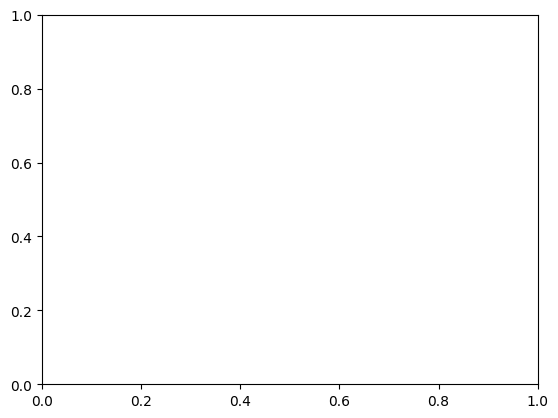

In [ ]:
# Train the model
def train_epoch(model,train_loader,optimizer,criterion,task,epoch,parameters):
    train_loss_epoch = 0

    for batch_idx, (X_batch, y_batch) in tqdm(enumerate(train_loader),total=len(train_loader)):
        outputs = model(X_batch)
        y_batch = y_batch.squeeze().long()

        loss = criterion(outputs,y_batch)

        train_loss_epoch += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss_epoch /= parameters["batch_size"]

    print(train_loss_epoch)
    return train_loss_epoch

def validate_epoch(model,valid_loader,criterion,task,epoch,parameters):
    valid_loss_epoch = 0

    y_true = torch.tensor([])
    y_score = torch.tensor([])

    with torch.no_grad():
      for batch_idx, (X_batch, y_batch) in tqdm(enumerate(valid_loader),total=len(valid_loader)):
          outputs = model(X_batch)
          y_batch = y_batch.squeeze().long()

          loss = criterion(outputs,y_batch)

          valid_loss_epoch += loss.item()

          outputs = outputs.softmax(1)
          y_batch = y_batch.resize_(len(y_batch),1)

          y_true = torch.cat((y_true, y_batch),0)
          y_score = torch.cat((y_score, outputs),0)

      y_true = y_true.numpy()
      y_score = y_score.detach().numpy()

      y_labels = np.argmax(y_score,1)[...,np.newaxis]

      acc = np.sum(y_true == y_labels) / np.sum(y_true == y_true)

      print(acc)

      valid_loss_epoch /= parameters["batch_size"]
      print(valid_loss_epoch)

      return valid_loss_epoch

def loss_function_graphics(epochs,train_loss_epoch,valid_loss_epoch):
  plt.plot(epochs, train_loss_epoch, 'b', label='Entrenamiento')
  plt.plot(epochs, valid_loss_epoch, 'r', label='Validación')
  plt.title('Funciones de Pérdida en Entrenamiento y Validación')
  plt.xlabel('Épocas')
  plt.ylabel('Pérdida')
  plt.legend()
  plt.show()

def model_training(train_loader,valid_loader,parameters):
  model = Net(parameters)
  #model = ResNet18(parameters)
  #model = UNetCNN(parameters)

  optimizer = torch.optim.Adam(model.parameters(),lr=parameters["lr"])
  criterion = nn.CrossEntropyLoss()

  #net_model_visualizer(model)

  train_loss_epoch = []
  valid_loss_epoch = []

  for epoch in range(parameters["num_epochs"]):
    model.train()
    train_loss = train_epoch(model,train_loader,optimizer,criterion,task,epoch,parameters)
    model.eval()
    valid_loss = validate_epoch(model,valid_loader,criterion,task,epoch,parameters)

    train_loss_epoch.append(train_loss)
    valid_loss_epoch.append(valid_loss)


  loss_function_graphics(parameters["num_epochs"],train_loss_epoch,valid_loss_epoch)



model_training(train_loader,valid_loader,parameters)

#Evaluation

Finally, implement the evaluation of the object clasification task. You can implement any metric you want, though the most common are accuracy and AUC (one class against all for the multiclass task). You can use torch.no_grad() for speeding up predictions when no gradients are needed.

How do you compare with the MedMNIST benchmarks?